In [36]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [163]:
#NBA COURT CHART
#Reference: https://github.com/bradleyfay/py-Goldsberry/blob/master/docs/Visualizing%20NBA%20Shots%20with%20py-Goldsberry.ipynb
#NBA court dimensions: https://official.nba.com/rule-no-1-court-dimensions-equipment/
#le dimensioni del campo sono tradotte nell'unità di misura del sistema di riferimento del grafico

#PARAMETRI DEL CAMPO
color = 'black'
lw = 2

def draw_court(ax=None):
        
    ax = plt.gca()

    # CREATE THE ELEMENTS OF THE COURT
    # Create the basketball hoop
    hoop = patches.Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = patches.Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # Create the paint
    
    paint_lines = patches.Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color, fill=False)
    
    # Create free throw top arc
    free_throw = patches.Arc((0, 142.5), 120, 120, theta1=0, theta2=180, linewidth=lw, color=color, fill=False)
    
    # Create restricted area
    restricted_area = patches.Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw, color=color)

    # Create three point lines
    #side 3pt lines
    right_corner_side_line = patches.Rectangle((-220, -47.5), 0, 137.5, linewidth=lw, color=color)
    left_corner_side_line = patches.Rectangle((220, -47.5), 0, 137.5, linewidth=lw, color=color)

    # 3pt arc
    three_arc = patches.Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw, color=color)


    # List of the court elements to be plotted onto the axes

    outer_lines = patches.Rectangle((-250, -47.5), 500, 470, linewidth=lw, color=color, fill=False)

    # Add the court elements onto the axes
    court_elements = [hoop, backboard, paint_lines, free_throw, restricted_area, right_corner_side_line, left_corner_side_line, three_arc, outer_lines]

    for element in court_elements:
        ax.add_patch(element)

    return ax


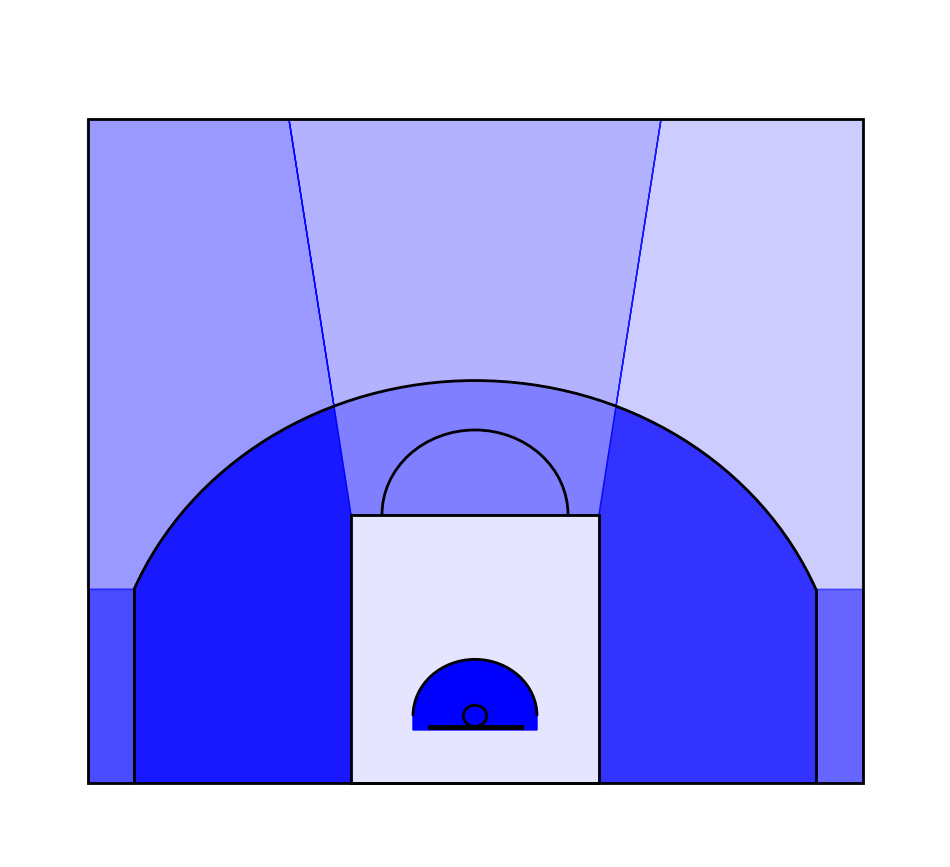

In [212]:
from shapely.geometry import Polygon
import matplotlib.patches as patches
# Impostare la figura e gli assi
fig, ax = plt.subplots(figsize=(12, 11))

# PARAMETRI PER IL DISEGNO DEL CAMPO
lw = 2
line_color = 'black'
fill_color = 'blue'

# Creare l'arco da tre punti
theta = np.linspace(np.radians(22), np.radians(158), 100)
arc_x = 237.5 * np.cos(theta)
arc_y = 237.5 * np.sin(theta)

# Creare l'arco della restricted area
# restricted_area = patches.Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw, color=color)

theta = np.linspace(np.radians(0), np.radians(180), 100)
restricted_x = 40 * np.cos(theta)
restricted_y = 40 * np.sin(theta)





# DEFINIZIONE DEI PUNTI DELLE DIVERSE AREE DI TIRO
# Arco da tre punti
Arc_points = np.column_stack((arc_x, arc_y))

# Tiro da tre punti
ThreePointArea_Left_points = [(250, 422.5), (250, 90), (220, 90), (80, 142.5), (120, 422.5)]

ThreePointArea_Center_points = [(80, 142.5), (120, 422.5), (-120, 422.5), (-80, 142.5)]

ThreePointArea_Right_points = [(-250, 422.5), (-250, 90), (-220, 90), (-80, 142.5), (-120, 422.5)]

# Tiro da tre punti (angoli)
LeftCornerThree_points = [(220, -47.5), (220, 90), (250, 90), (250, -47.5)]

RightCornerThree_points = [(-220, -47.5), (-220, 90), (-250, 90), (-250, -47.5)]


# Mid Range
MidRange_Left_points_Aux = [(120, 422.5), (80, 142.5), (80, -47.5), (220, -47.5), (220, 422.5)]
MidRange_Center_points = [(-80, 142.5), (-120, 422.5), (120, 422.5), (80, 142.5)]
MidRange_Right_points_Aux = [(-120, 422.5), (-80, 142.5), (-80, -47.5), (-220, -47.5), (-220, 422.5)]

# Pitturato
Paint_points = [(80, -47.5), (80, 142.5), (-80, 142.5), (-80, -47.5)]

# Restricted Area
#Aggiungo i punti per un rettangolo tra la restricheted area e il tabellone
Restricted_Area_points1 = np.column_stack((restricted_x, restricted_y))
Restriced_Area_points2 = [(40, 0), (40, -10), (-40, -10), (-40, 0)]
Restricted_Area_points = np.vstack((Restricted_Area_points1, Restriced_Area_points2))


# CREAZIONE DEGLI OGGETTI POLYGON
# Arco da tre punti
# Oggetto ausiliario per costruire i diversi poligoni da plottare
Arc_Pol = Polygon(Arc_points)

# Tiro da tre punti
ThreePointArea_Left_Aux = Polygon(ThreePointArea_Left_points)
ThreePointArea_Center_Aux = Polygon(ThreePointArea_Center_points)
ThreePointArea_Right_Aux = Polygon(ThreePointArea_Right_points)
LeftCornerThree = Polygon(LeftCornerThree_points)
RightCornerThree = Polygon(RightCornerThree_points)

# Mid Range
MidRange_Left_Aux = Polygon(MidRange_Left_points_Aux)
MidRange_Center_Aux = Polygon(MidRange_Center_points)
MidRange_Right_Aux = Polygon(MidRange_Right_points_Aux)

# Pitturato
Paint = Polygon(Paint_points)

# Restricted Area
Restricted_Area = Polygon(Restricted_Area_points)


# CALCOLO DELLA DIFFERENZA TRA I POLYGON

# Tiro da tre punti
ThreePointArea_Left = ThreePointArea_Left_Aux.difference(Arc_Pol)
ThreePointArea_Center = ThreePointArea_Center_Aux.difference(Arc_Pol)
ThreePointArea_Right = ThreePointArea_Right_Aux.difference(Arc_Pol)

# Mid Range
MidRange_Center_Aux1 = MidRange_Center_Aux.difference(ThreePointArea_Center)
MidRange_Center = MidRange_Center_Aux1.difference(Paint)
MidRange_Left = MidRange_Left_Aux.difference(ThreePointArea_Left)
MidRange_Right = MidRange_Right_Aux.difference(ThreePointArea_Right)

# Pitturato
#Paint = Paint.difference(Restricted_Area)


# DISEGNO DELLE AREE DI TIRO

# Tiro da tre punti
plt.fill(*ThreePointArea_Left.exterior.xy, color=fill_color, alpha=0.2)
plt.fill(*ThreePointArea_Center.exterior.xy, color=fill_color, alpha=0.3)
plt.fill(*ThreePointArea_Right.exterior.xy, color=fill_color, alpha=0.4)

# Tiro da tre punti (angoli)
plt.fill(*LeftCornerThree.exterior.xy, color=fill_color, alpha=0.6)
plt.fill(*RightCornerThree.exterior.xy, color=fill_color, alpha=0.7)

# Mid Range
plt.fill(*MidRange_Center.exterior.xy, color=fill_color, alpha=0.5)
plt.fill(*MidRange_Left.exterior.xy, color=fill_color, alpha=0.8)
plt.fill(*MidRange_Right.exterior.xy, color=fill_color, alpha=0.9)

# Pitturato
plt.fill(*Paint.exterior.xy, color=fill_color, alpha=0.1)

# Restricted Area
plt.fill(*Restricted_Area.exterior.xy, color=fill_color, alpha=1)





# Disegno il campo con la funzione draw_court
draw_court(ax=ax)

# Impostare i limiti degli assi per visualizzare l'intera area
plt.xlim(-300, 300)
plt.ylim(-100, 500)

# Rimuovere gli assi
plt.axis('off')

# Mostrare la figura
plt.show()


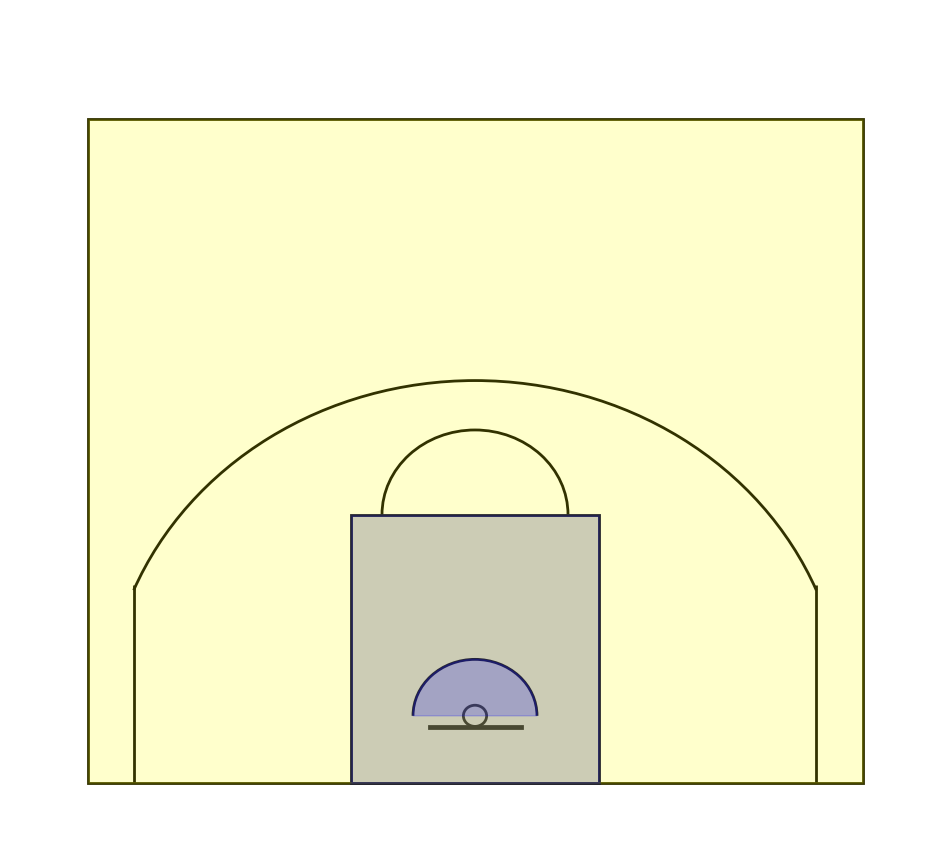

In [40]:
# creo delle figure per coprire le diverse aree del campo

# paint
paint = patches.Rectangle((-80, -47.5), 160, 190, linewidth=2, color='blue', fill=True, alpha=0.2)

# restricted area (filled)
restricted_area = patches.Wedge((0,0), 40, theta1=0, theta2=180, facecolor='blue', edgecolor='blue', alpha=0.2)

#outside the 3 pt line




#print pitturato
plt.figure(figsize=(12,11))
draw_court(outer_lines=True)
plt.xlim(-300,300)
plt.ylim(-100,500)
plt.gca().add_patch(paint)
plt.gca().add_patch(restricted_area)
plt.axis("off")
plt.show()



In [130]:
# Read in the data
df = pd.read_pickle("LeBronShots.pickle")

#ritorno le coordinate del punto di tiro nella zona center più a sinistra

x = min(df[(df.Area == 'Center(C)')].LOC_X)

print(x)



-100


Aggiunta dei tiri di Lebron nel periodo compreso tra la stagione 2003-04 e la stagione 2009-10 (inclusa)

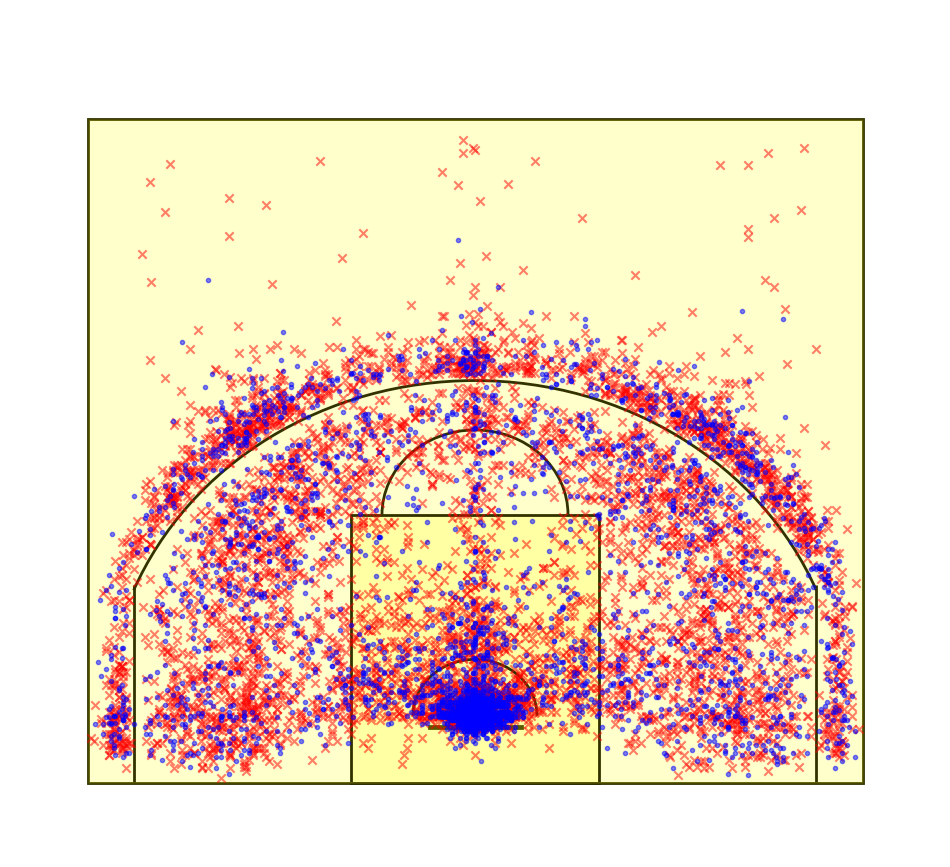

In [42]:
# missed shot = x
# made shot = o
#shots since 2003-04 to 2009-10
Seasons = ['2003-04', '2004-05', '2005-06', '2006-07', '2007-08', '2008-09', '2009-10']

made_shots = df[(df.FG == 1) & (df.SEASON.isin(Seasons)) & (df.LOC_Y < 422.5)]
missed_shots = df[(df.FG == 0) & (df.SEASON.isin(Seasons))& (df.LOC_Y < 422.5)]

# Plot the shots
plt.figure(figsize=(12,11))
draw_court(outer_lines=True)
plt.scatter(missed_shots.LOC_X, missed_shots.LOC_Y, marker='x', color="red", alpha=0.5, label="Missed Shot")
plt.scatter(made_shots.LOC_X, made_shots.LOC_Y, marker='.', color="blue", alpha=0.5, label="Made Shot")
plt.xlim(-300,300)
plt.ylim(-100,500)
plt.axis("off")
plt.show()



In [43]:
Seasons = ['2003-04', '2004-05', '2005-06', '2006-07', '2007-08', '2008-09', '2009-10']
# rappresento la percentuale di tiri presi in ogni zona del campo, divisi per Area e zona
# il campo è diviso in Left Side, Right Side, , Center, ognuna di queste è divisa in tMid-Range, In The Paint (Non Restricted), Restricted Area, Above the Break 3, Corner 3


# Prendo l'insieme zona e area dal dataset e calcolo la percentuale di tiri presi in ogni zona rispetto al totale

#calcolo il totale dei tiri presi in ogni zona
#Left Side Mid-Range
LS_Mid = df[(df.Area == 'Left Side(L)') & (df.Zone == 'Mid-Range') & (df.SEASON.isin(Seasons))].shape[0]


#Left Side Above the Break 3
LS_Above = df[(df.Area == 'Left Side(L)') & (df.Zone == 'Above the Break 3') & (df.SEASON.isin(Seasons))].shape[0]

#Left Side Corner 3
LS_Corner = df[(df.Zone == 'Left Corner 3') & (df.SEASON.isin(Seasons))].shape[0]



#Right Side Mid-Range
RS_Mid = df[(df.Area == 'Right Side(R)') & (df.Zone == 'Mid-Range') & (df.SEASON.isin(Seasons))].shape[0]

#Right Side Above the Break 3
RS_Above = df[(df.Area == 'Right Side(R)') & (df.Zone == 'Above the Break 3') & (df.SEASON.isin(Seasons))].shape[0]

#Right Side Corner 3
RS_Corner = df[(df.Zone == 'Right Corner 3') & (df.SEASON.isin(Seasons))].shape[0]


#Center Mid-Range
C_Mid = df[(df.Area == 'Center(C)') & (df.Zone == 'Mid-Range') & (df.SEASON.isin(Seasons))].shape[0]

#In The Paint (Non Restricted)
Paint = df[(df.Zone == 'In The Paint (Non-RA)') & (df.SEASON.isin(Seasons))].shape[0]

#Restricted Area
Restricted = df[(df.Zone == 'Restricted Area') & (df.SEASON.isin(Seasons))].shape[0]

#Center Above the Break 3
C_Above = df[(df.Area == 'Center(C)') & (df.Zone == 'Above the Break 3') & (df.SEASON.isin(Seasons))].shape[0]



total = df[df.SEASON.isin(Seasons)].shape[0]
lS_Mid_Perc = LS_Mid / total * 100
lS_Above_Perc = LS_Above / total * 100
lS_Corner_Perc = LS_Corner / total * 100

rS_Mid_Perc = RS_Mid / total * 100
rS_Above_Perc = RS_Above / total * 100
rS_Corner_Perc = RS_Corner / total * 100

c_Mid_Perc = C_Mid / total * 100
restricted_Perc = Restricted / total * 100
paint_Perc = Paint / total * 100
c_Above_Perc = C_Above / total * 100

print('Left Side Mid-Range:', lS_Mid_Perc)
print('Left Side Above the Break 3:', lS_Above_Perc)
print('Left Side Corner 3:', lS_Corner_Perc)

print('Right Side Mid-Range:', rS_Mid_Perc)
print('Right Side Above the Break 3:', rS_Above_Perc)
print('Right Side Corner 3:', rS_Corner_Perc)

print('Center Mid-Range:', c_Mid_Perc)
print('Restricted Area:', restricted_Perc)
print('In The Paint (Non Restricted):', paint_Perc)
print('Center Above the Break 3:', c_Above_Perc)

Left Side Mid-Range: 15.219244246614263
Left Side Above the Break 3: 6.790415759068094
Left Side Corner 3: 1.5910597594469174
Right Side Mid-Range: 15.219244246614263
Right Side Above the Break 3: 5.805474003220002
Right Side Corner 3: 1.6857656975092339
Center Mid-Range: 3.9492376171985986
Restricted Area: 35.34425608485652
In The Paint (Non Restricted): 10.256653092148877
Center Above the Break 3: 3.854531679136282


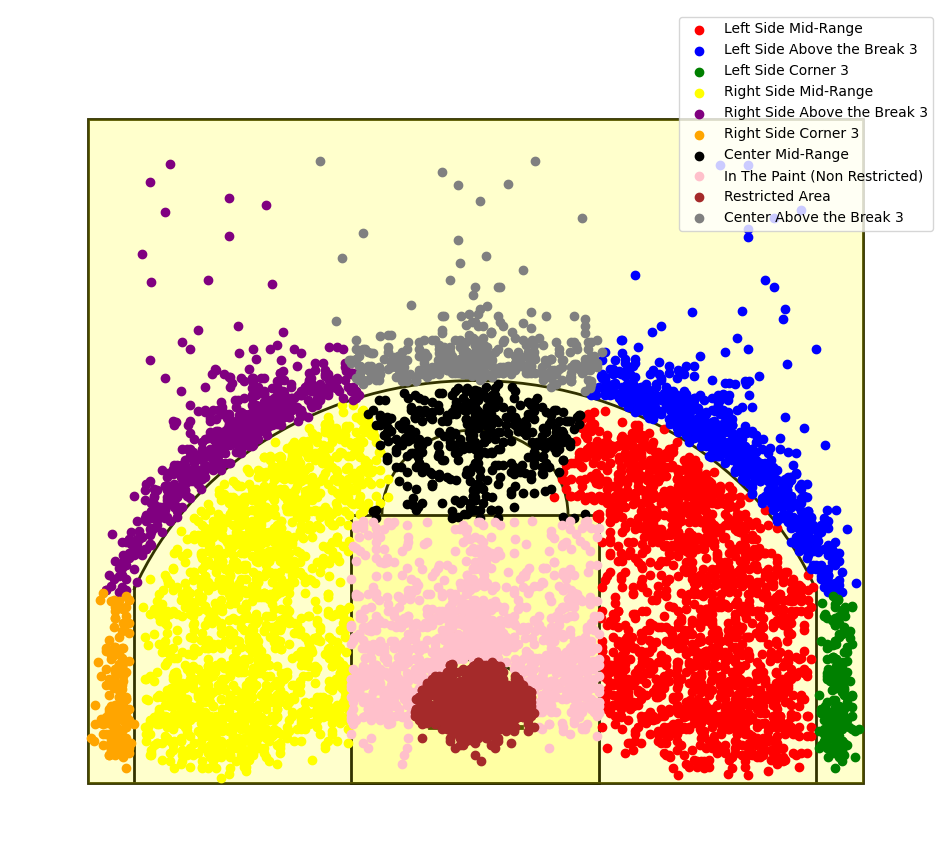

In [44]:
Seasons = ['2003-04', '2004-05', '2005-06', '2006-07', '2007-08', '2008-09', '2009-10']

#plotto il grafico diviso in Zone come sopra descritto con le percentuali di tiri presi in ogni zona

#definisco le zone del campo nel grafico sul court

#Left Side Mid-Range
LS_Mid = df[(df.Area == 'Left Side(L)') & (df.Zone == 'Mid-Range') & (df.SEASON.isin(Seasons))]
#Left Side Above the Break 3
LS_Above = df[(df.Area == 'Left Side(L)') & (df.Zone == 'Above the Break 3') & (df.SEASON.isin(Seasons))]
#Left Side Corner 3
LS_Corner = df[(df.Zone == 'Left Corner 3') & (df.SEASON.isin(Seasons))]
#Right Side Mid-Range
RS_Mid = df[(df.Area == 'Right Side(R)') & (df.Zone == 'Mid-Range') & (df.SEASON.isin(Seasons))]
#Right Side Above the Break 3
RS_Above = df[(df.Area == 'Right Side(R)') & (df.Zone == 'Above the Break 3') & (df.SEASON.isin(Seasons))]
#Right Side Corner 3
RS_Corner = df[(df.Zone == 'Right Corner 3') & (df.SEASON.isin(Seasons))]
#Center Mid-Range
C_Mid = df[(df.Area == 'Center(C)') & (df.Zone == 'Mid-Range') & (df.SEASON.isin(Seasons))]
#In The Paint (Non Restricted)
Paint = df[(df.Zone == 'In The Paint (Non-RA)') & (df.SEASON.isin(Seasons))]
#Restricted Area
Restricted = df[(df.Zone == 'Restricted Area') & (df.SEASON.isin(Seasons))]
#Center Above the Break 3
C_Above = df[(df.Area == 'Center(C)') & (df.Zone == 'Above the Break 3') & (df.SEASON.isin(Seasons))]

#plotto il grafico
plt.figure(figsize=(12,11))
draw_court(outer_lines=True)
plt.scatter(LS_Mid.LOC_X, LS_Mid.LOC_Y, color='red', label='Left Side Mid-Range')
plt.scatter(LS_Above.LOC_X, LS_Above.LOC_Y, color='blue', label='Left Side Above the Break 3')
plt.scatter(LS_Corner.LOC_X, LS_Corner.LOC_Y, color='green', label='Left Side Corner 3')
plt.scatter(RS_Mid.LOC_X, RS_Mid.LOC_Y, color='yellow', label='Right Side Mid-Range')
plt.scatter(RS_Above.LOC_X, RS_Above.LOC_Y, color='purple', label='Right Side Above the Break 3')
plt.scatter(RS_Corner.LOC_X, RS_Corner.LOC_Y, color='orange', label='Right Side Corner 3')
plt.scatter(C_Mid.LOC_X, C_Mid.LOC_Y, color='black', label='Center Mid-Range')
plt.scatter(Paint.LOC_X, Paint.LOC_Y, color='pink', label='In The Paint (Non Restricted)')
plt.scatter(Restricted.LOC_X, Restricted.LOC_Y, color='brown', label='Restricted Area')
plt.scatter(C_Above.LOC_X, C_Above.LOC_Y, color='grey', label='Center Above the Break 3')
plt.xlim(-300,300)
plt.ylim(-100,500)
plt.axis("off")
plt.legend()
plt.show()



              

In [45]:
Seasons = ['2010-11', '2011-12', '2012-13', '2013-14']
# rappresento la percentuale di tiri presi in ogni zona del campo, divisi per Area e zona
# il campo è diviso in Left Side, Right Side, , Center, ognuna di queste è divisa in tMid-Range, In The Paint (Non Restricted), Restricted Area, Above the Break 3, Corner 3


# Prendo l'insieme zona e area dal dataset e calcolo la percentuale di tiri presi in ogni zona rispetto al totale


#calcolo il totale dei tiri presi in ogni zona
#Left Side Mid-Range
LS_Mid = df[(df.Area == 'Left Side(L)') & (df.Zone == 'Mid-Range') & (df.SEASON.isin(Seasons))].shape[0]


#Left Side Above the Break 3
LS_Above = df[(df.Area == 'Left Side(L)') & (df.Zone == 'Above the Break 3') & (df.SEASON.isin(Seasons))].shape[0]

#Left Side Corner 3
LS_Corner = df[(df.Zone == 'Left Corner 3') & (df.SEASON.isin(Seasons))].shape[0]


#Right Side Mid-Range
RS_Mid = df[(df.Area == 'Right Side(R)') & (df.Zone == 'Mid-Range') & (df.SEASON.isin(Seasons))].shape[0]



#Right Side Above the Break 3
RS_Above = df[(df.Area == 'Right Side(R)') & (df.Zone == 'Above the Break 3') & (df.SEASON.isin(Seasons))].shape[0]

#Right Side Corner 3
RS_Corner = df[(df.Zone == 'Right Corner 3') & (df.SEASON.isin(Seasons))].shape[0]


#Center Mid-Range
C_Mid = df[(df.Area == 'Center(C)') & (df.Zone == 'Mid-Range') & (df.SEASON.isin(Seasons))].shape[0]


#In The Paint (Non Restricted)

Paint = df[(df.Zone == 'In The Paint (Non-RA)') & (df.SEASON.isin(Seasons))].shape[0]

#Restricted Area
Restricted = df[(df.Zone == 'Restricted Area') & (df.SEASON.isin(Seasons))].shape[0]

#Center Above the Break 3
C_Above = df[(df.Area == 'Center(C)') & (df.Zone == 'Above the Break 3') & (df.SEASON.isin(Seasons))].shape[0]

total = df[df.SEASON.isin(Seasons)].shape[0]
lS_Mid_Perc = LS_Mid / total * 100
lS_Above_Perc = LS_Above / total * 100
lS_Corner_Perc = LS_Corner / total * 100

rS_Mid_Perc = RS_Mid / total * 100
rS_Above_Perc = RS_Above / total * 100
rS_Corner_Perc = RS_Corner / total * 100

c_Mid_Perc = C_Mid / total * 100
restricted_Perc = Restricted / total * 100
paint_Perc = Paint / total * 100
c_Above_Perc = C_Above / total * 100

print('Left Side Mid-Range:', lS_Mid_Perc)
print('Left Side Above the Break 3:', lS_Above_Perc)
print('Left Side Corner 3:', lS_Corner_Perc)

print('Right Side Mid-Range:', rS_Mid_Perc)
print('Right Side Above the Break 3:', rS_Above_Perc)
print('Right Side Corner 3:', rS_Corner_Perc)

print('Center Mid-Range:', c_Mid_Perc)
print('Restricted Area:', restricted_Perc)
print('In The Paint (Non Restricted):', paint_Perc)
print('Center Above the Break 3:', c_Above_Perc)

Left Side Mid-Range: 17.089201877934272
Left Side Above the Break 3: 6.685446009389671
Left Side Corner 3: 1.3708920187793427
Right Side Mid-Range: 10.854460093896714
Right Side Above the Break 3: 5.652582159624413
Right Side Corner 3: 1.6901408450704223
Center Mid-Range: 3.830985915492958
Restricted Area: 36.82629107981221
In The Paint (Non Restricted): 12.281690140845072
Center Above the Break 3: 3.511737089201878


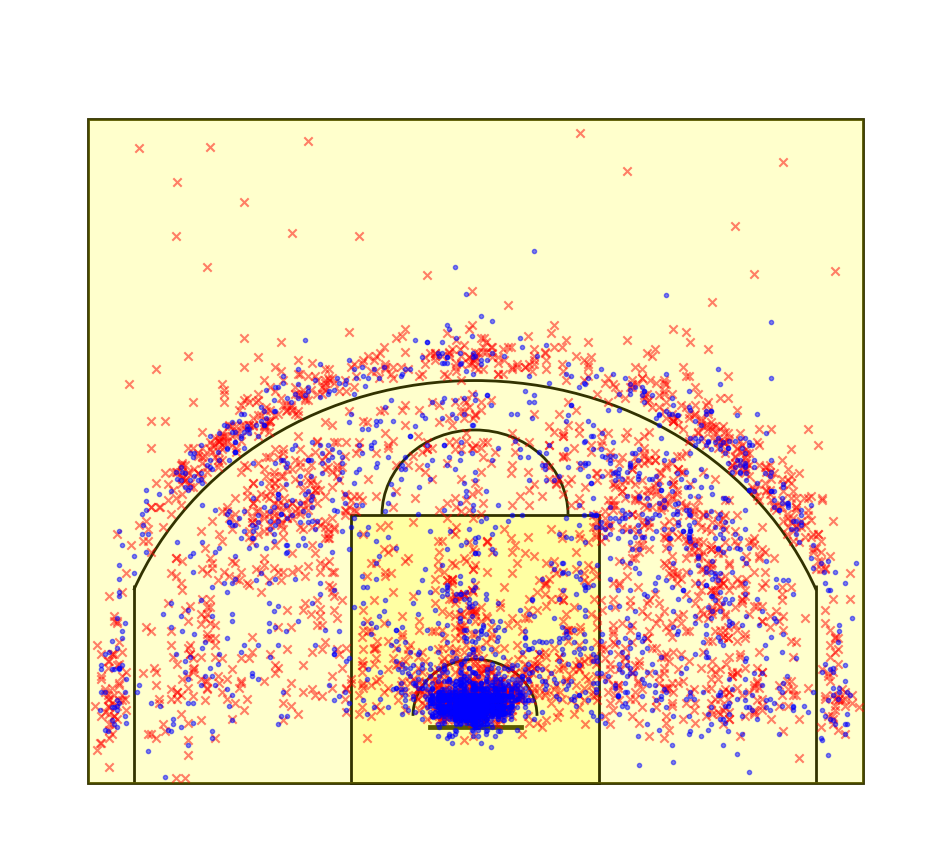

In [47]:
Seasons2 = ['2010-11', '2011-12', '2012-13', '2013-14']

made_shots = df[(df.FG == 1) & (df.SEASON.isin(Seasons2)) & (df.LOC_Y < 422.5)]
missed_shots = df[(df.FG == 0) & (df.SEASON.isin(Seasons2)) & (df.LOC_Y < 422.5)]

# Plot the shots
plt.figure(figsize=(12,11))
draw_court(outer_lines=True)
plt.scatter(missed_shots.LOC_X, missed_shots.LOC_Y, marker='x', color="red", alpha=0.5, label="Missed Shot")
plt.scatter(made_shots.LOC_X, made_shots.LOC_Y, marker='.', color="blue",alpha=0.5, label="Made Shot")
plt.xlim(-300,300)
plt.ylim(-100,500)
plt.axis("off")
plt.show()


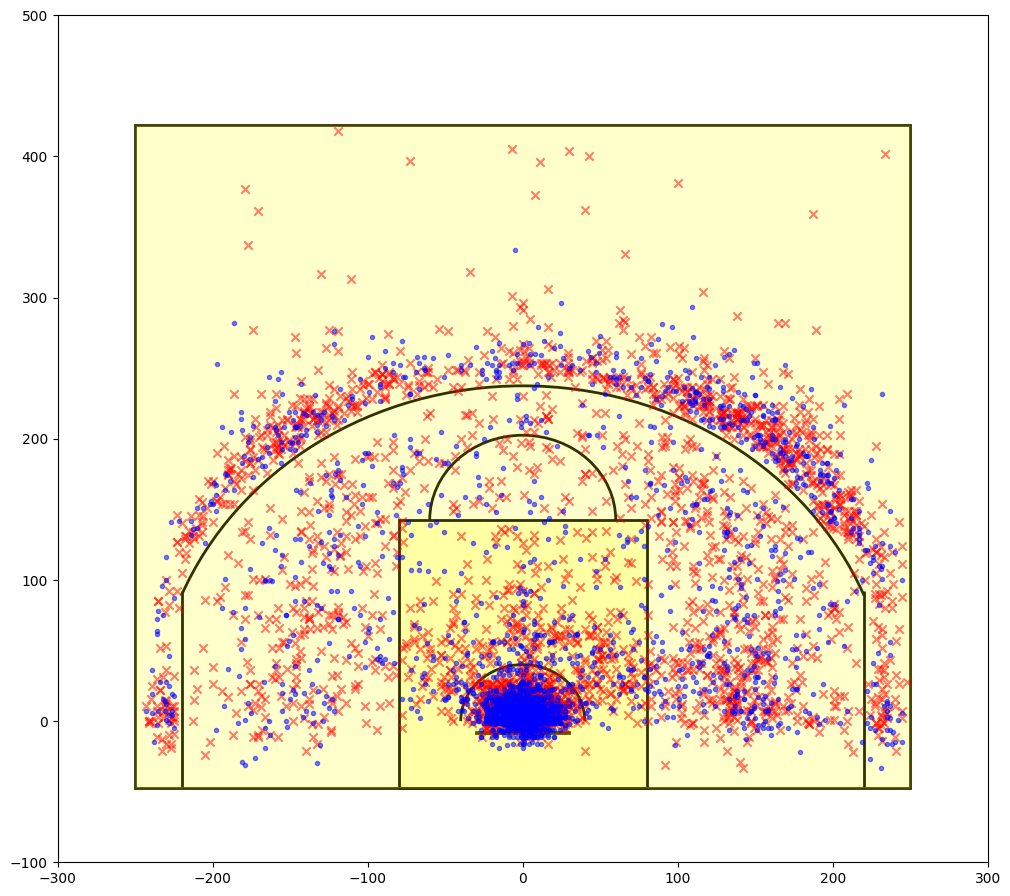

In [48]:
Seasons3 = ['2014-15', '2015-16', '2016-17', '2017-18']


made_shots = df[(df.FG == 1) & (df.SEASON.isin(Seasons3)) & (df.LOC_Y < 422.5)]
missed_shots = df[(df.FG == 0) & (df.SEASON.isin(Seasons3)) & (df.LOC_Y < 422.5)]

# Plot the shots
plt.figure(figsize=(12,11))
draw_court(outer_lines=True)
plt.scatter(missed_shots.LOC_X, missed_shots.LOC_Y, marker='x', color="red", alpha=0.5, label="Missed Shot")
plt.scatter(made_shots.LOC_X, made_shots.LOC_Y, marker='.', color="blue", alpha=0.5, label="Made Shot")
plt.xlim(-300,300)
plt.ylim(-100,500)
#plt.axis("off")
plt.show()

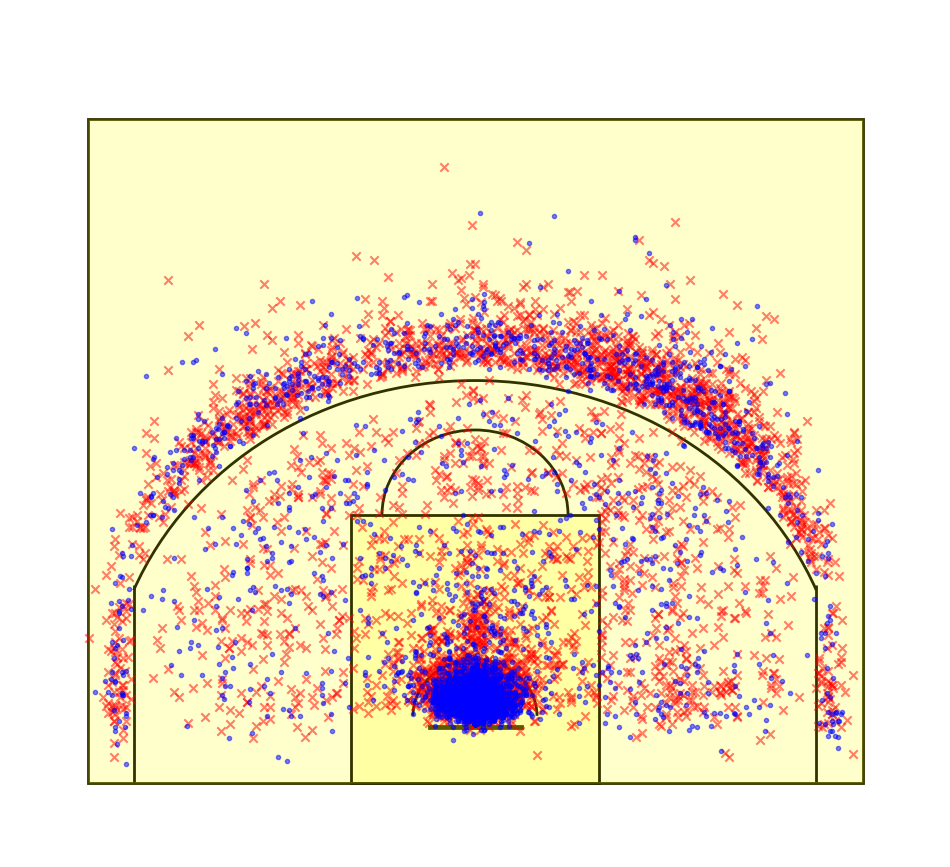

In [49]:
Seasons4 = ['2018-19', '2019-20', '2020-21', '2021-22', '2022-23', '2023-24'] 


made_shots = df[(df.FG == 1) & (df.SEASON.isin(Seasons4)) & (df.LOC_Y < 422.5)]
missed_shots = df[(df.FG == 0) & (df.SEASON.isin(Seasons4)) & (df.LOC_Y < 422.5)]

# Plot the shots
plt.figure(figsize=(12,11))
draw_court(outer_lines=True)
plt.scatter(missed_shots.LOC_X, missed_shots.LOC_Y, marker='x', color="red", alpha=0.5, label="Missed Shot")
plt.scatter(made_shots.LOC_X, made_shots.LOC_Y, marker='.', color="blue", alpha=0.5, label="Made Shot")
plt.xlim(-300,300)
plt.ylim(-100,500)
plt.axis("off")
plt.show()